In this notebook, we will analyze stock data sourced from Alpha Vantage. Our workflow will include:

   1. Feature Engineering – Creating meaningful features from raw stock data to enhance our analysis and modeling.

   2. Data Visualization – Exploring trends, patterns, and relationships in the data through visualizations.

   3. Predictive Modeling – Building a model to forecast stock behavior using the engineered features.

By the end of this notebook, we aim to uncover insights from historical stock data and demonstrate a predictive approach that can inform trading or investment decisions.

In [2]:
# Connect to AlphaVantage and collect stock data
import requests
from dotenv import load_dotenv
from os import getenv

load_dotenv()
API_KEY = getenv("ALPHAVANTAGE_API_KEY")

symbol = "SPY"
url = (f"https://www.alphavantage.co/query"
        + "?function=TIME_SERIES_DAILY"
        + f"&symbol={symbol}"
        + f"&apikey={API_KEY}"
        #+ "&outputsize=full"
      )
r = requests.get(url)
data = r.json()


In [3]:
# Print relevant metadata
print("DATA:         ", data.get("Meta Data").get("1. Information"))
print("SYMBOL:       ", data.get("Meta Data").get("2. Symbol"))
print("REFRESH DATE: ", data.get("Meta Data").get("3. Last Refreshed"))

DATA:          Daily Prices (open, high, low, close) and Volumes
SYMBOL:        SPY
REFRESH DATE:  2025-10-21


In [4]:
# Load data into a pandas DataFrame
import pandas as pd

df = pd.DataFrame.from_dict(data.get("Time Series (Daily)"), orient='index')
df.index.name = 'date'
df.reset_index(inplace=True)
df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']

print(df)

          date      open      high       low     close     volume
0   2025-10-21  671.4400  672.9900  669.9810  671.2900   56249034
1   2025-10-20  667.3200  672.2100  667.2700  671.3000   60493350
2   2025-10-17  659.5000  665.7550  658.1400  664.3900   96500870
3   2025-10-16  666.8200  668.7100  657.1100  660.6400  110563346
4   2025-10-15  666.8200  670.2300  658.9300  665.1700   81702555
..         ...       ...       ...       ...       ...        ...
95  2025-06-05  597.6300  599.0000  591.0500  593.0500   92436397
96  2025-06-04  596.9600  597.9500  595.4900  595.9300   57314199
97  2025-06-03  592.3400  597.0800  591.8500  596.0900   63606204
98  2025-06-02  587.7600  592.7900  585.0600  592.7100   61630502
99  2025-05-30  588.9300  591.1299  583.2350  589.3900   90601242

[100 rows x 6 columns]


In [5]:
# Convert columns to float
df['open'] = df['open'].astype(float)
df['close'] = df['close'].astype(float)
df['volume'] = df['volume'].astype(float)
df['high'] = df['high'].astype(float)
df['low'] = df['low'].astype(float)

In [6]:
import numpy as np

df["day's range"] = df['close'] - df['open']
df['price difference'] = df['high'] - df['low']
df['day to day'] = df['close'] - df['open'].shift(1)
df['log returns'] = np.log(df['close'] / df['close'].shift(1))                       

In [7]:
# Overall range
overall_range = df['close'].max() - df['open'].min()
print("Overall Open-to-Close Range:", overall_range)

Overall Open-to-Close Range: 85.35000000000002


In [8]:
# Sort by date just in case
df = df.sort_values('date')

# Day-to-day volume change
df['volume_change'] = df['volume'] - df['volume'].shift(1)

# Optional: percentage change
df['volume_pct_change'] = df['volume'].pct_change() * 100

# Calculate Price / Volume for each row (using Close price)
df['price by volume'] = df['close'] / df['volume']

In [9]:
# Initialize OBV
df['obv'] = 0

# Loop method
for i in range(1, len(df)):
    if df['close'].iloc[i] > df['close'].iloc[i-1]:
        df['obv'].iloc[i] = df['obv'].iloc[i-1] + df['volume'].iloc[i]
    elif df['close'].iloc[i] < df['close'].iloc[i-1]:
        df['obv'].iloc[i] = df['obv'].iloc[i-1] - df['volume'].iloc[i]
    else:
        df['obv'].iloc[i] = df['obv'].iloc[i-1]

# 7-day moving average of volume
df['volume_ma7'] = df['volume'].rolling(window=7).mean()

/var/folders/cl/t0tgh5md7pj6srx85p45398h0000gq/T/ipykernel_28151/4093249856.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['obv'].iloc[i] = df['obv'].iloc[i-1] + df['volume'].iloc[i]
/var/folders/cl/t0tgh5md7pj6srx85p45398h0000gq/T/i

In [10]:
df.head(5)

,date,open,high,low,close,volume,day's range,price difference,day to day,log returns,volume_change,volume_pct_change,price by volume,obv,volume_ma7
99,2025-05-30,588.93,591.1299,583.235,589.39,90601242.0,0.46,7.8949,1.63,-0.005617,NaN,NaN,0.000007,0,NaN
98,2025-06-02,587.76,592.7900,585.060,592.71,61630502.0,4.95,7.7300,0.37,-0.005686,-28970740.0,-31.976096,0.000010,61630502,NaN
97,2025-06-03,592.34,597.0800,591.850,596.09,63606204.0,3.75,5.2300,-0.87,0.000268,1975702.0,3.205721,0.000009,125236706,NaN
96,2025-06-04,596.96,597.9500,595.490,595.93,57314199.0,-1.03,2.4600,-1.70,0.004844,-6292005.0,-9.892125,0.000010,67922507,NaN
95,2025-06-05,597.63,599.0000,591.050,593.05,92436397.0,-4.58,7.9500,-5.61,-0.010217,35122198.0,61.280099,0.000006,-24513890,NaN


In [11]:
# Create lag features for close and volume
lag_days = [1, 2, 3]  # 1-day, 2-day, 3-day lags

for lag in lag_days:
    df[f'close_lag_{lag}'] = df['close'].shift(lag)
    df[f'volume_lag_{lag}'] = df['volume'].shift(lag)
    df[f'price_by_volume_lag_{lag}'] = (df['close'] * df['volume']).shift(lag)

# View result
print(df[['date', 'close', 'close_lag_1', 'close_lag_2', 'close_lag_3',
          'volume', 'volume_lag_1', 'volume_lag_2', 'volume_lag_3']])

          date   close  close_lag_1  close_lag_2  close_lag_3       volume  \
99  2025-05-30  589.39          NaN          NaN          NaN   90601242.0   
98  2025-06-02  592.71       589.39          NaN          NaN   61630502.0   
97  2025-06-03  596.09       592.71       589.39          NaN   63606204.0   
96  2025-06-04  595.93       596.09       592.71       589.39   57314199.0   
95  2025-06-05  593.05       595.93       596.09       592.71   92436397.0   
..         ...     ...          ...          ...          ...          ...   
4   2025-10-15  665.17       662.23       663.04       653.02   81702555.0   
3   2025-10-16  660.64       665.17       662.23       663.04  110563346.0   
2   2025-10-17  664.39       660.64       665.17       662.23   96500870.0   
1   2025-10-20  671.30       664.39       660.64       665.17   60493350.0   
0   2025-10-21  671.29       671.30       664.39       660.64   56249034.0   

    volume_lag_1  volume_lag_2  volume_lag_3  
99           NaN

                      close    volume  price by volume  log returns  \
close              1.000000 -0.001037         0.196112     0.149654   
volume            -0.001037  1.000000        -0.917987    -0.315237   
price by volume    0.196112 -0.917987         1.000000     0.274243   
log returns        0.149654 -0.315237         0.274243     1.000000   
day to day         0.036941 -0.203299         0.131860     0.503582   
volume_change     -0.039727  0.615590        -0.541260    -0.200463   
volume_pct_change -0.017173  0.666973        -0.605181    -0.192042   
obv                0.787049 -0.095827         0.249304     0.239103   

                   day to day  volume_change  volume_pct_change       obv  
close                0.036941      -0.039727          -0.017173  0.787049  
volume              -0.203299       0.615590           0.666973 -0.095827  
price by volume      0.131860      -0.541260          -0.605181  0.249304  
log returns          0.503582      -0.200463          -0

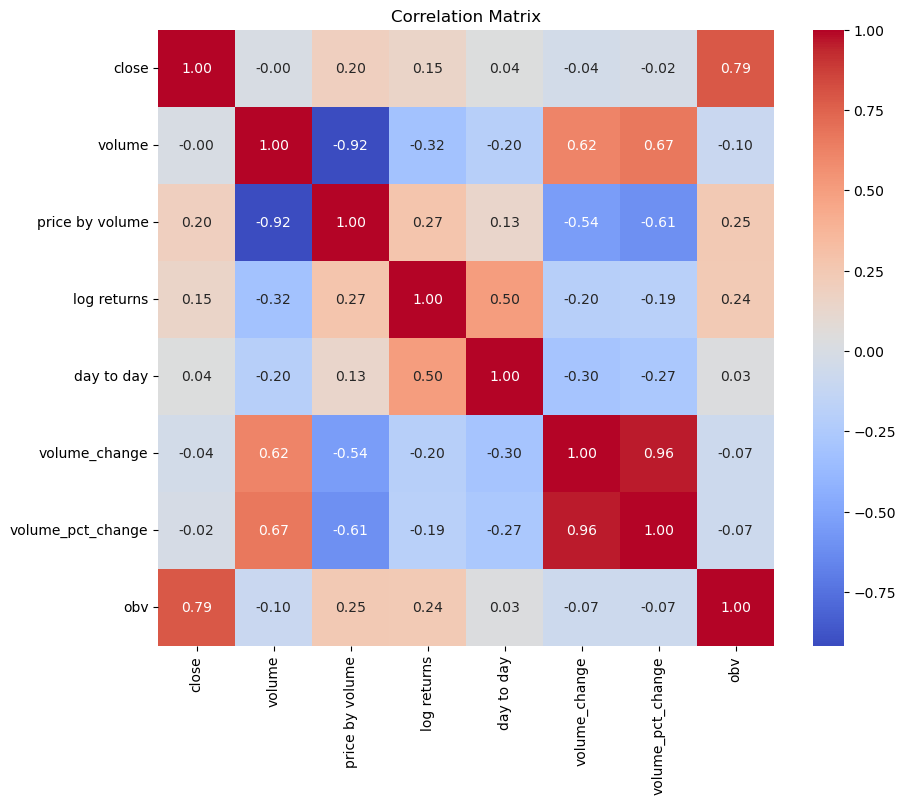

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric columns you want to check correlations for
numeric_cols = ['close', 'volume', 'price by volume', 'log returns', 
                'day to day', 'volume_change', 'volume_pct_change', 'obv']

# Calculate correlation matrix
corr_matrix = df[numeric_cols].corr()

# Display correlation matrix
print(corr_matrix)

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

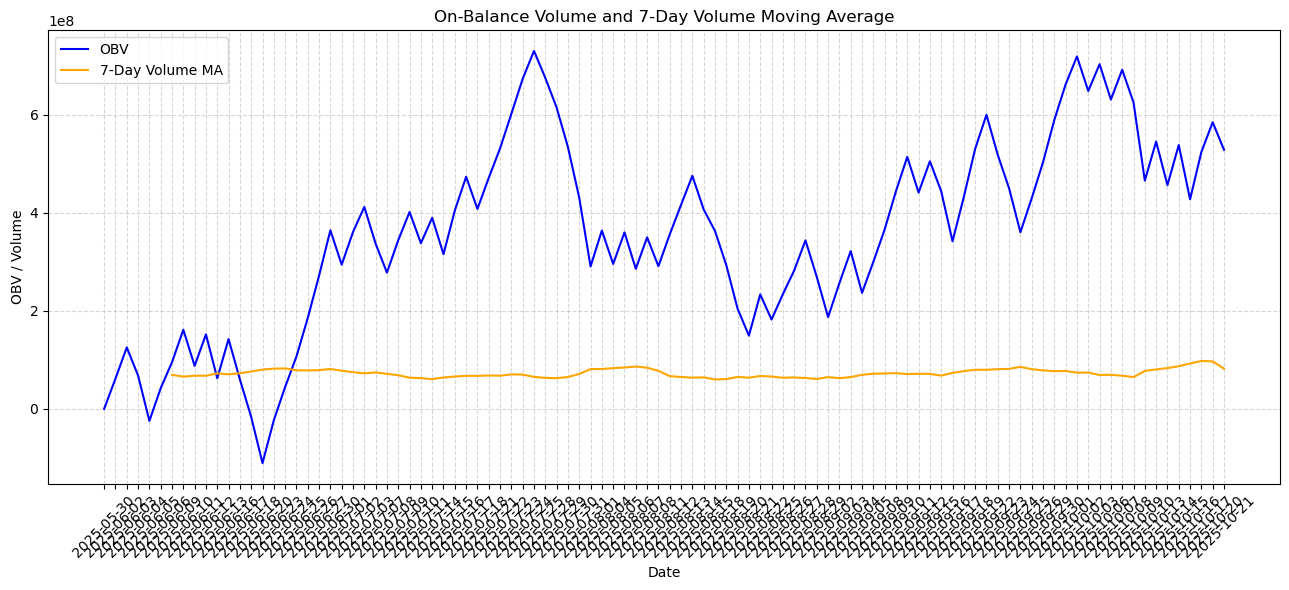

In [13]:
plt.figure(figsize=(13,6))

# OBV line
plt.plot(df['date'], df['obv'], color='blue', label='OBV')

# Volume moving average line
plt.plot(df['date'], df['volume_ma7'], color='orange', label='7-Day Volume MA')

plt.xlabel('Date')
plt.ylabel('OBV / Volume')
plt.title('On-Balance Volume and 7-Day Volume Moving Average')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

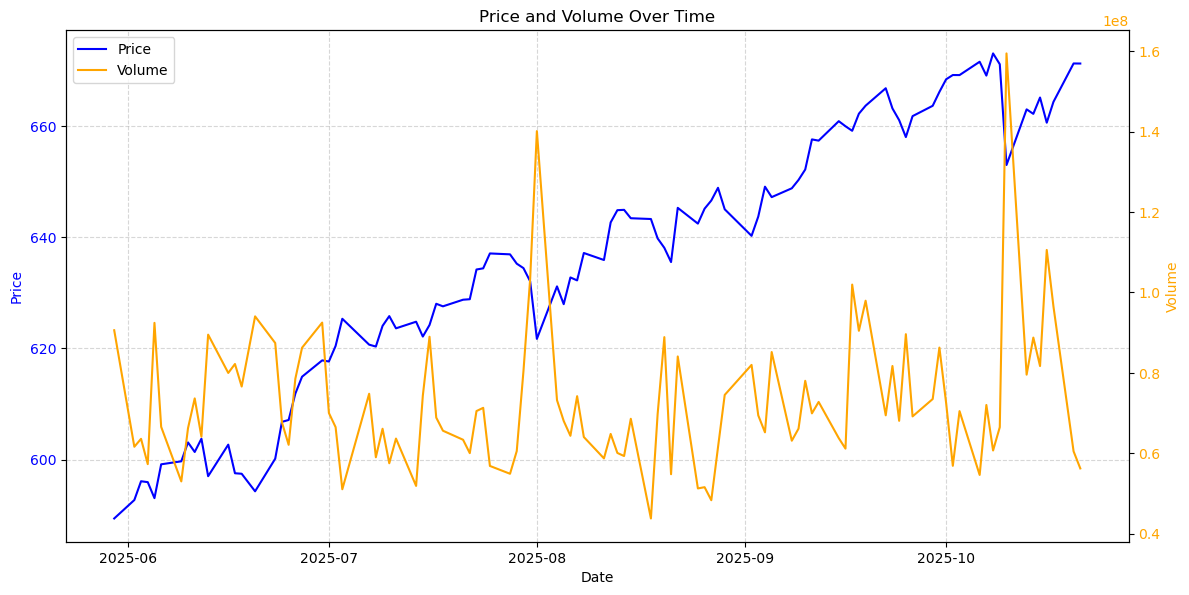

In [14]:
df['date'] = pd.to_datetime(df['date'])

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot price on left Y-axis
ax1.plot(df['date'], df['close'], color='blue', label='Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.5)

# Create second Y-axis for volume
ax2 = ax1.twinx()
ax2.plot(df['date'], df['volume'], color='orange', label='Volume')
ax2.set_ylabel('Volume', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title and legend
fig.tight_layout()
plt.title('Price and Volume Over Time')

# Show combined legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()

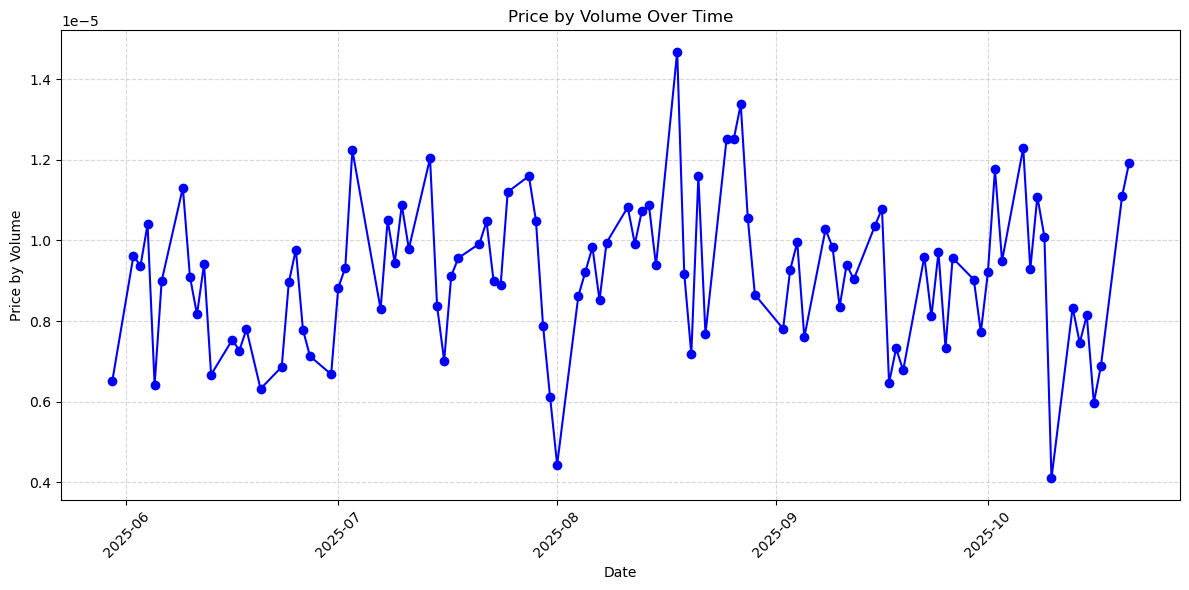

In [15]:
# Plot line graph
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['price by volume'], marker='o', linestyle='-', color='blue')
plt.xlabel('Date')
plt.ylabel('Price by Volume')
plt.title('Price by Volume Over Time')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

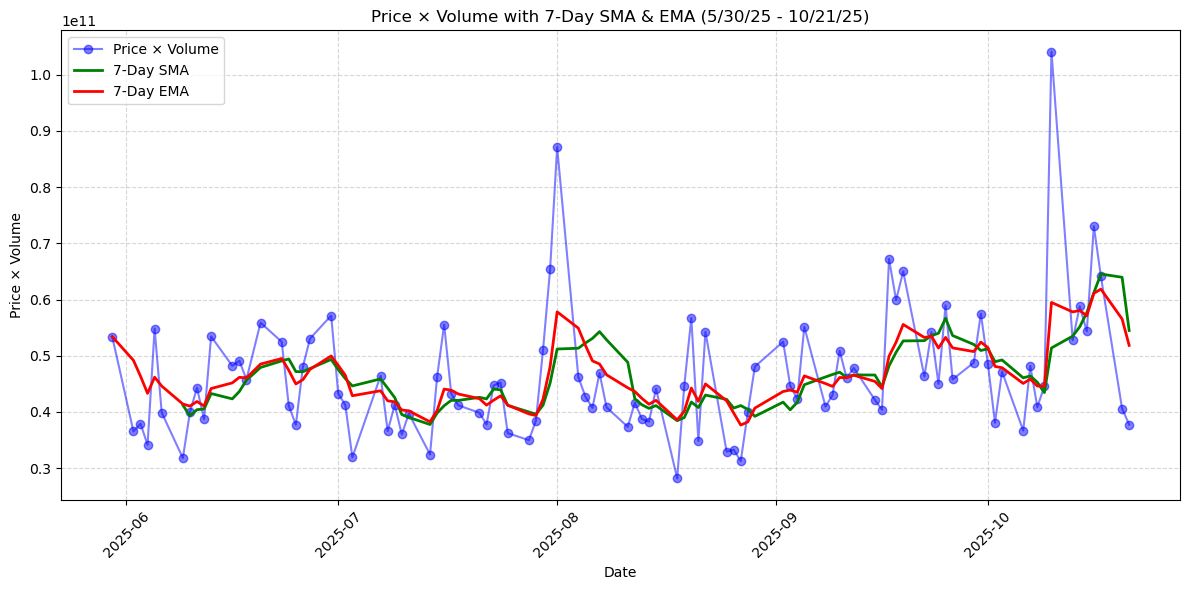

In [16]:
# Calculate Price × Volume
df['price by volume'] = df['close'] * df['volume']

# Calculate 7-day SMA
df['sma7'] = df['price by volume'].rolling(window=7).mean()

# Calculate 7-day EMA
df['ema7'] = df['price by volume'].ewm(span=7, adjust=False).mean()

# Plot
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['price by volume'], marker='o', linestyle='-', alpha=0.5, label='Price × Volume', color='blue')
plt.plot(df['date'], df['sma7'], color='green', linewidth=2, label='7-Day SMA')
plt.plot(df['date'], df['ema7'], color='red', linewidth=2, label='7-Day EMA')

plt.xlabel('Date')
plt.ylabel('Price × Volume')
plt.title('Price × Volume with 7-Day SMA & EMA (5/30/25 - 10/21/25)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Bullish SMA crossovers:
          date          sma7         sma30
63 2025-07-23  4.407959e+10  4.407931e+10
57 2025-07-31  4.514351e+10  4.399792e+10
32 2025-09-05  4.484316e+10  4.431543e+10
7  2025-10-10  5.138942e+10  5.036063e+10
Bearish SMA crossovers:
          date          sma7         sma30
62 2025-07-24  4.393715e+10  4.425553e+10
49 2025-08-12  4.234517e+10  4.374212e+10
11 2025-10-06  4.606819e+10  4.701435e+10
Bullish EMA crossovers:
          date          ema7         ema30
85 2025-06-20  4.852009e+10  4.821848e+10
79 2025-06-30  4.996878e+10  4.836686e+10
57 2025-07-31  4.804283e+10  4.455566e+10
41 2025-08-22  4.499088e+10  4.442603e+10
35 2025-09-02  4.364099e+10  4.313494e+10
7  2025-10-10  5.948557e+10  5.060330e+10
Bearish EMA crossovers:
          date          ema7         ema30
83 2025-06-24  4.740555e+10  4.801577e+10
77 2025-07-02  4.653417e+10  4.760019e+10
50 2025-08-11  4.429460e+10  4.562259e+10
40 2025-08-25  4.197871e+10  4.368514e+10
13 2025-10-02  4.8

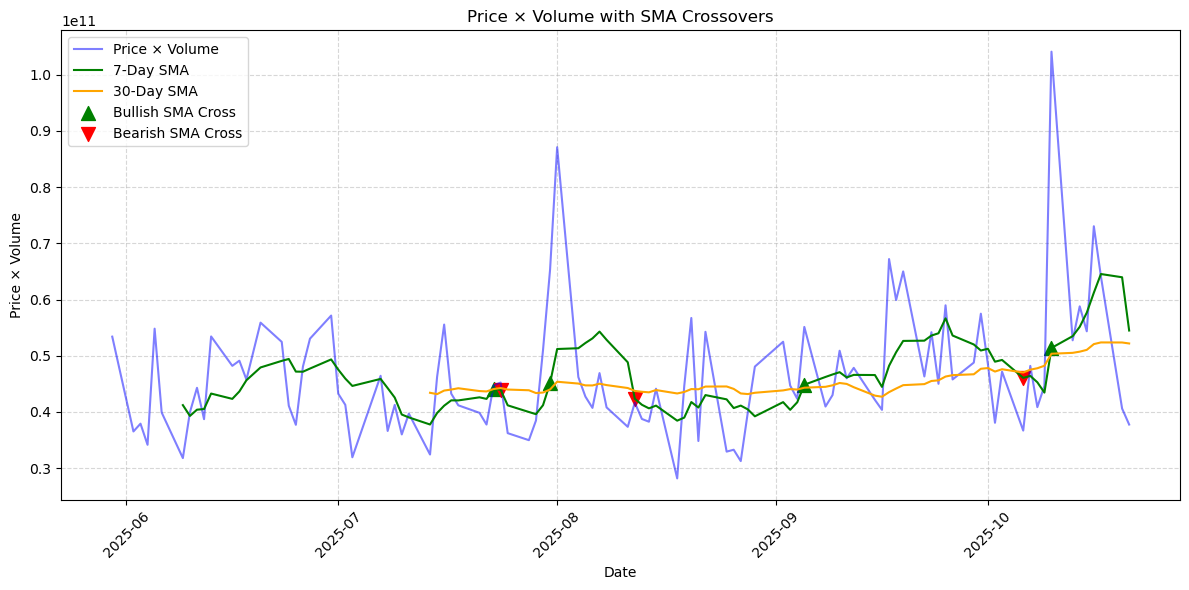

In [17]:
# Short-term and long-term SMAs
df['sma30'] = df['price by volume'].rolling(window=30).mean()

# Short-term and long-term EMAs
df['ema30'] = df['price by volume'].ewm(span=30, adjust=False).mean()

# Find crossover signals (SMA example)
df['sma_signal'] = np.where(df['sma7'] > df['sma30'], 1, 0)  # 1 = bullish, 0 = bearish
df['sma_crossover'] = df['sma_signal'].diff()  # 1 = buy, -1 = sell

# Find crossover signals (EMA example)
df['ema_signal'] = np.where(df['ema7'] > df['ema30'], 1, 0)
df['ema_crossover'] = df['ema_signal'].diff()

# Print crossover points
bullish_sma = df[df['sma_crossover'] == 1]
bearish_sma = df[df['sma_crossover'] == -1]

bullish_ema = df[df['ema_crossover'] == 1]
bearish_ema = df[df['ema_crossover'] == -1]

print("Bullish SMA crossovers:\n", bullish_sma[['date', 'sma7', 'sma30']])
print("Bearish SMA crossovers:\n", bearish_sma[['date', 'sma7', 'sma30']])
print("Bullish EMA crossovers:\n", bullish_ema[['date', 'ema7', 'ema30']])
print("Bearish EMA crossovers:\n", bearish_ema[['date', 'ema7', 'ema30']])

# Optional: plot SMA crossovers
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['price by volume'], color='blue', alpha=0.5, label='Price × Volume')
plt.plot(df['date'], df['sma7'], color='green', label='7-Day SMA')
plt.plot(df['date'], df['sma30'], color='orange', label='30-Day SMA')

# Mark bullish and bearish crossovers
plt.scatter(bullish_sma['date'], bullish_sma['sma7'], marker='^', color='g', s=100, label='Bullish SMA Cross')
plt.scatter(bearish_sma['date'], bearish_sma['sma7'], marker='v', color='r', s=100, label='Bearish SMA Cross')

plt.xlabel('Date')
plt.ylabel('Price × Volume')
plt.title('Price × Volume with SMA Crossovers')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

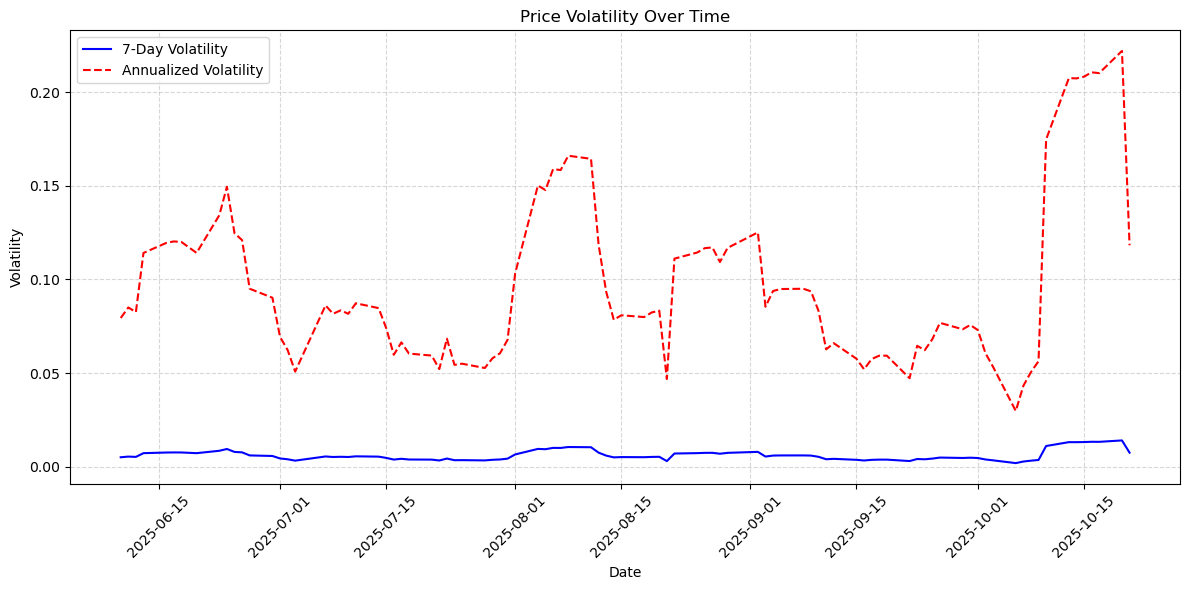

In [18]:
# Calculate daily returns
df['returns'] = df['close'].pct_change()

# Calculate rolling volatility (e.g., 7-day)
df['volatility_7d'] = df['returns'].rolling(window=7).std()

# Optional: annualized volatility (assuming 252 trading days)
df['volatility_annualized'] = df['volatility_7d'] * np.sqrt(252)

# Plot rolling volatility
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['volatility_7d'], label='7-Day Volatility', color='blue')
plt.plot(df['date'], df['volatility_annualized'], label='Annualized Volatility', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Price Volatility Over Time')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

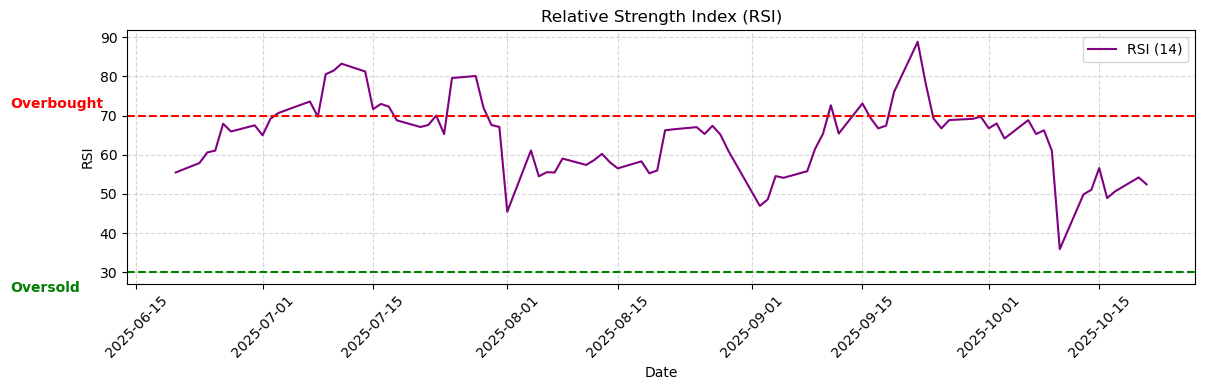

In [19]:
# Calculate daily returns
delta = df['close'].diff()

# Separate gains and losses
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

# Calculate average gain/loss
window = 14
avg_gain = gain.rolling(window=window).mean()
avg_loss = loss.rolling(window=window).mean()

# Calculate RS and RSI
rs = avg_gain / avg_loss
df['rsi'] = 100 - (100 / (1 + rs))

# Plot RSI
plt.figure(figsize=(12,4))
plt.plot(df['date'], df['rsi'], color='purple', label='RSI (14)')
plt.axhline(70, color='red', linestyle='--')  # overbought
plt.axhline(30, color='green', linestyle='--')  # oversold
plt.text(df['date'].iloc[0], 70+2, 'Overbought', color='red', fontsize=10, fontweight='bold')
plt.text(df['date'].iloc[0], 30-5, 'Oversold', color='green', fontsize=10, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.title('Relative Strength Index (RSI)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

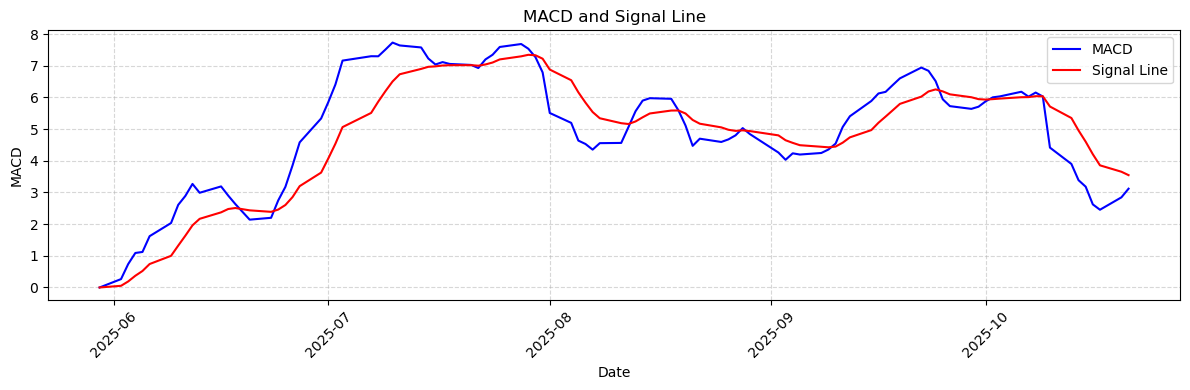

In [20]:
# Calculate MACD
ema12 = df['close'].ewm(span=12, adjust=False).mean()
ema26 = df['close'].ewm(span=26, adjust=False).mean()
df['macd'] = ema12 - ema26

# Signal line
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

# Plot MACD
plt.figure(figsize=(12,4))
plt.plot(df['date'], df['macd'], label='MACD', color='blue')
plt.plot(df['date'], df['macd_signal'], label='Signal Line', color='red')
plt.xlabel('Date')
plt.ylabel('MACD')
plt.title('MACD and Signal Line')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
# Ensure date is datetime
df['date'] = pd.to_datetime(df['date'])

# Create day of week column (0=Monday, 6=Sunday)
df['day_of_week'] = df['date'].dt.dayofweek

# Create day-of-week one-hot
df = pd.concat([df, pd.get_dummies(df['day_of_week'], prefix='dow')], axis=1)

# Check which columns exist
print(df.filter(like='dow_').columns)

Index(['dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4'], dtype='object')


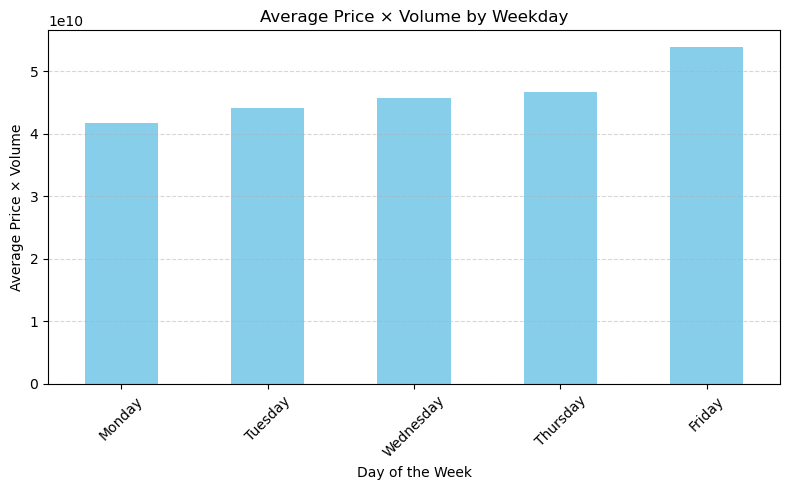

In [27]:
# Group by day_of_week and calculate average Price × Volume
avg_price_by_volume = df.groupby('day_of_week')['price by volume'].mean()

# Map day numbers to weekday names
weekday_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday'}
avg_price_by_volume.index = avg_price_by_volume.index.map(weekday_names)

# Plot
plt.figure(figsize=(8,5))
avg_price_by_volume.plot(kind='bar', color='skyblue')
plt.xlabel('Day of the Week')
plt.ylabel('Average Price × Volume')
plt.title('Average Price × Volume by Weekday')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

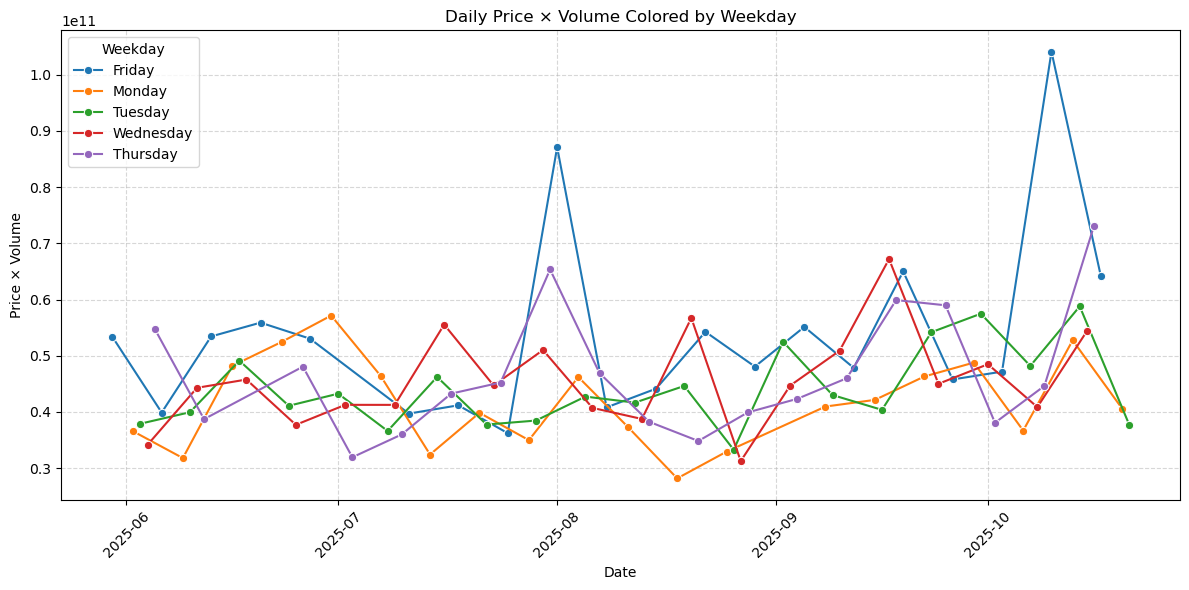

In [31]:
# Map numeric day_of_week to names
weekday_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday'}
df['weekday_name'] = df['day_of_week'].map(weekday_names)

# Set a color palette for weekdays
palette = sns.color_palette("tab10", n_colors=5)  # 5 weekdays

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='date', y='price by volume', hue='weekday_name', palette=palette, marker='o')

plt.xlabel('Date')
plt.ylabel('Price × Volume')
plt.title('Daily Price × Volume Colored by Weekday')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Weekday')
plt.tight_layout()
plt.show()

In [61]:
#Average of close, volume by day of week
df.groupby('day_of_week')[['close', 'volume', 'price by volume']].mean()

,close,volume,price by volume
day_of_week,,,
0,636.167000,6.555691e+07,4.163893e+10
1,636.475714,6.915761e+07,4.404822e+10
2,636.231000,7.181811e+07,4.573507e+10
3,639.164211,7.296533e+07,4.664624e+10
4,634.625500,8.480089e+07,5.381648e+10


In [49]:
#Volatility by day of week
df.groupby('day_of_week')['log returns'].std()

day_of_week
0    0.005305
1    0.003543
2    0.005089
3    0.009863
4    0.005868
Name: log returns, dtype: float64

In [51]:
#Average daily return by day of week
df.groupby('day_of_week')['day to day'].mean()

day_of_week
0   -0.154000
1   -1.150000
2   -0.863750
3   -0.027895
4   -0.957000
Name: day to day, dtype: float64

In [53]:
#Which days have unusually high trading activity
threshold = df['volume'].mean() + df['volume'].std()
df[df['volume'] > threshold].groupby('day_of_week').size()

day_of_week
0    1
2    1
3    4
4    6
dtype: int64

In [55]:
#Correlation of pbv and daily by day of week
df.groupby('day_of_week')[['price by volume','day to day']].corr().iloc[0::2,-1]

day_of_week                 
0            price by volume    0.351567
1            price by volume   -0.048839
2            price by volume   -0.132386
3            price by volume    0.031574
4            price by volume   -0.538207
Name: day to day, dtype: float64

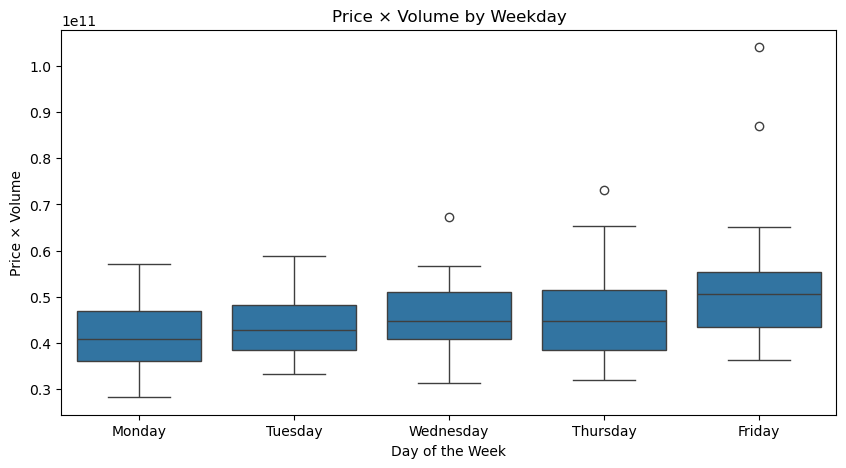

In [65]:
import seaborn as sns

# Define weekday order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# Boxplot with correct weekday order
plt.figure(figsize=(10,5))
sns.boxplot(x='weekday_name', y='price by volume', data=df, order=weekday_order)
plt.xlabel('Day of the Week')
plt.ylabel('Price × Volume')
plt.title('Price × Volume by Weekday')
plt.show()

In [73]:
# Overall skewness
print("Skewness of Price × Volume:", df['price by volume'].skew())
if df['price by volume'].skew() > 0:
    print('Skewed Right')
if df['price by volume'].skew() < 0:
    print('Skewed Left')
if df['price by volume'].skew() == 0:
    print('Roughly Symmetric')
print("Skewness of Volume:", df['volume'].skew())
if df['volume'].skew() > 0:
    print('Skewed Right')
if df['volume'].skew() < 0:
    print('Skewed Left')
if df['volume'].skew() == 0:
    print('Roughly Symmetric')
print("Skewness of Close:", df['close'].skew())
if df['close'].skew() > 0:
    print('Skewed Right')
if df['close'].skew() < 0:
    print('Skewed Left')
if df['close'].skew() == 0:
    print('Roughly Symmetric')

Skewness of Price × Volume: 2.024265713634567
Skewed Right
Skewness of Volume: 1.9643188705734398
Skewed Right
Skewness of Close: -0.29915735251331976
Skewed Left


In [85]:
# Skewness of Price × Volume by day of week
skew_by_day = df.groupby('day_of_week')['price by volume'].skew()

# Map numeric day to names for readability
weekday_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday'}
skew_by_day.index = skew_by_day.index.map(weekday_names)

# Interpret skewness for each day
for day, skew in skew_by_day.items():
    if skew > 0:
        interpretation = 'Skewed Right: Investors should be aware of potential for extreme gains'
    elif skew < 0:
        interpretation = 'Skewed Left: Could indicate risk of sharp losses or market inactivity'
    else:
        interpretation = 'Roughly Symmetric: Daily price changes or trading volume are more predictable'
    print(f"{day}: {skew:.2f} → {interpretation}")

# Print the skew values as well
print("\nSkewness values by day:")
print(skew_by_day)

Monday: 0.22 → Skewed Right: Investors should be aware of potential for extreme gains
Tuesday: 0.76 → Skewed Right: Investors should be aware of potential for extreme gains
Wednesday: 0.70 → Skewed Right: Investors should be aware of potential for extreme gains
Thursday: 0.99 → Skewed Right: Investors should be aware of potential for extreme gains
Friday: 1.94 → Skewed Right: Investors should be aware of potential for extreme gains

Skewness values by day:
day_of_week
Monday       0.217596
Tuesday      0.759245
Wednesday    0.695803
Thursday     0.987246
Friday       1.940849
Name: price by volume, dtype: float64
